$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{Universidad de los Andes}$$
$$\textrm{Grupo de Física de Altas Energías: Fenomenología de Partículas}$$

$\textbf{Preliminares}$ 

Las librerías que se usan en este capítulo son las siguientes: 

In [1]:
import os, sys

Path_Tutorials = os.path.dirname(os.path.realpath('Capitulo_4_Stack_y_No_Stack_de_los_histogramas.ipynb'))
Path_Pheno_BSM = os.path.dirname(Path_Tutorials)
sys.path.append(Path_Pheno_BSM)

from ROOT import TH1F #Permite graficar los histogramas usando ROOT
from ROOT import TCanvas #Permite poner los histogramas
from ROOT import TFile #Permite guardar y leer los histogramas en un archivo .root
from ROOT import THStack #Permite graficar varios histogramas al mismo tiempo
from ROOT import TLegend #Permite poner legends cuando se sobrelapan histogramas

from delphes_reader import DelphesLoader 
import pandas as pd
import numpy as np

from IPython.display import clear_output #Permite limpiar la línea del output para que no se imprima nada (es algo estético que se usa a veces) 
import nbimporter #Permite importar otros notebooks y usar sus funciones
personal_folder = f'{Path_Pheno_BSM}/Tutorials'

Welcome to JupyROOT 6.26/06


En este capítulo se utilizan la lista signals y el directorio XS por esto es necesario volverlos a definir para no tener inconvenientes:

In [2]:
#Definamos una lista con las señales y un directorio para guardar las secciones eficaces:

signals = ["z", "w_jets", "ww", "wz", "zz", "ttbar", "stop"]
XS = {}

#XS de señal:
tabla_ij = pd.read_html(f'{personal_folder}/Data_Z/crossx.html')
columna_xs = tabla_ij[0]['Cross section (pb)']
XS['z'] = float(columna_xs[0].split(' ')[0])    

#XS de backgrounds:
BKGs = ["w_jets", "ww", "wz", "zz", "ttbar", "stop"]

for BKG in BKGs:
    Delphes_Process = DelphesLoader(BKG) #Se crea un objeto de la clase DelphesLoader correspondiente al proceso BKG
    XS[BKG] = float(Delphes_Process.xs) #Extrae la sección eficaz del BKG -  esta en pb
clear_output(wait=False)

In [3]:
#Importemos las funciones Eficiencia y Luminosidad del capitulo 3
from Capitulo_3_Guardado_de_los_histogramas_en_un_archivo_root import Eficiencia 
from Capitulo_3_Guardado_de_los_histogramas_en_un_archivo_root import Luminosidad

$\textbf{Lectura del archivo.root con los histogramas}$ 

El objetivo aquí es reconstruir los directorios que teníamos antes con los histogramas extrayendo todo del archivo .root, hagámoslo primero con el archivo ejemplo.root que es más sencillo: 

In [4]:
rootFile = TFile.Open('ejemplo.root', 'READ') #Lee el archivo .root
directorio = rootFile.GetDirectory('carpeta') #Busca la carpeta llamada carpeta
histograma = directorio.Get("Histograma") #Buscar el archivo llamado Histograma (así lo llamamos arriba) dentro del directorio
histograma.SetDirectory(0) #Desliga el histograma del archivo.root, si no se pone esto entonces al cerrar el archivo .root la información del hsitograma se pierde
rootFile.Close() #Se cierra el archivo.root

Gracias a que usamos histograma.SetDirectory(0) es posible acceder al histograma después de cerrar ejemplo.root, hagámoslo: 

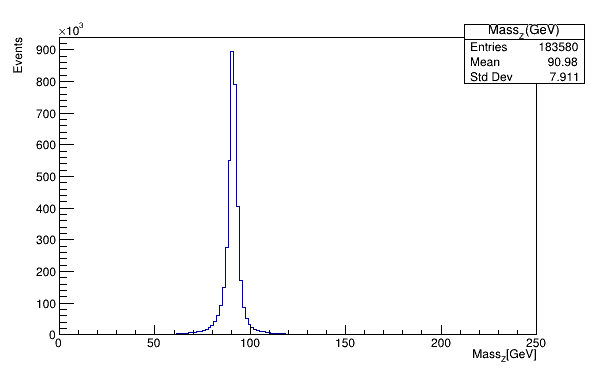

In [5]:
canvas = TCanvas("Canvas", " ", 600, 400)
histograma.Draw('hist')
canvas.Draw()

Ahora podemos complificar este razonamiento para recuperar los diccionarios con histogramas que teníamos antes, para esto primero definámoslos:

In [6]:
histogramas_muon0 = {}
histogramas_muon1 = {}
histogramas_correlation = {}
histogramas_Z = {}
histogramas = {}

Ahora llenémoslos leyendo el archivo Histogramas.root, notemos que para esto se necesitaría conocer el nombre de las subcarpetas y todo, para esto basta uno abrirlos con TBrowser, anotar los nombres y pensar en una forma de acceder a ellos, eso es lo más real, en el caso del tutorial se podría tratar de usar las keys de algunos DataSets creados en otros capítulos ya que concordarían gracias a la manera en que está escrito el código; sin embargo, tratemos de hacerlo real. 

Simplemente habría que escribir los nombres de las variables cinemáticas para cada carpeta del archivo.root 

In [7]:
Cinematica_Z = ['pT_{Z}(GeV)', '#eta_{Z}', '#phi_{Z}', 'Energy_{Z}(GeV)','Mass_{Z}(GeV)']
Cinematica_muons = ['pT_{#mu}(GeV)', '#eta_{#mu}', '#phi_{#mu}', 'Energy_{#mu}(GeV)','Mass_{#mu}(GeV)']
Cinematica_correlation = ['pT_{#mu}(GeV)', '#eta_{#mu}', '#phi_{#mu}', 'Energy_{#mu}(GeV)', 'Mass_{#mu}(GeV)', '#Delta{R}_{#mu#mu}', '#Delta{#eta}_{#mu#mu}','#Delta{#phi}_{#mu#mu}', '#Delta{pT}_{#mu#mu}(GeV)','#Delta{#vec{pT}}_{#mu#mu}(GeV)', '#Delta{#vec{p}}_{#mu#mu}(GeV)']


Ese es el razonamiento que se aplicará para buscar los histogramas dentro del archivo .root, dicho esto, ahora si leámoslo y llenemos los diccionarios: 

In [8]:
def Read_ROOT_File(nombre, carpeta, Dict_Histogramas, Variables_Cinematicas, signals):

    #nombre: es el nombre del archivo.root que queremos leer
    #carpeta: es el nombre de la carpeta del archivo.root que queremos leer
    #signals: Arreglo con los nombres de las subcarpetas que queremos leer, en este caso corresponden a los keys de Paths
    #Variables_Cinematicas: Son los nombres de los histogramas
    
    ROOT_File = TFile.Open(nombre, 'READ') #Lee el archivo .root
    dir_carpeta = ROOT_File.GetDirectory(carpeta) #Busca la carpeta llamada carpeta
    
    for signal in signals:
        dir_signal = dir_carpeta.GetDirectory(signal)
        histogramas_signal = {} #Directorio para guaradr los histogramas de una señal

        for hist_name in Variables_Cinematicas:
            histograma = dir_signal.Get(hist_name) #Se extrae el histograma

            if histograma: #Solo se corre si el histograma existe, esto es importante debido a que hay señales que pueden no tener algun histograma y sino la siguiente linea provocará un error
                histograma.SetDirectory(0) #Desliga el histograma del archivo.root, si no se pone esto entonces al cerrar el archivo .root la información del hsitograma se pierde
                histogramas_signal[hist_name] = histograma #Se añade el histograma al diccionario temporal de la señal dada

        Dict_Histogramas[signal] = histogramas_signal #Se actualiza el diccionario principal
    ROOT_File.Close() #Se cierra el archivo.root

Cabe resaltar que uno podría escribir una función que requiriera menos parámetros utilizando todas las keys de los diccionarios que hemos definido en este tutorial; sin embargo, la idea es que este código se pueda pensar en aplicar a otros archivos.root que pueden tener otra estructura. En la realidad lo que se haría sería abrir el archivo.root usando TBrowser y explorarlo un poco, luego usar este método para extraer la carpeta, subcarpetas e histogramas que a uno le interesen. 

In [9]:
Read_ROOT_File('Histogramas.root', 'muon0', histogramas_muon0, Cinematica_muons, signals)
Read_ROOT_File('Histogramas.root', 'muon1', histogramas_muon1, Cinematica_muons, signals)
Read_ROOT_File('Histogramas.root', 'correlation', histogramas_correlation, Cinematica_correlation, signals)
Read_ROOT_File('Histogramas.root', 'Z', histogramas_Z, Cinematica_Z, signals)

histogramas = {'muon0': histogramas_muon0, 'muon1': histogramas_muon1, 'correlation': histogramas_correlation, 'Z': histogramas_Z}

Veamos que efectivamente se recupera lo que teníamos antes:

In [10]:
histogramas

{'muon0': {'z': {'pT_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x562f6b9242f0>,
   '#eta_{#mu}': <cppyy.gbl.TH1F object at 0x562f6b923aa0>,
   '#phi_{#mu}': <cppyy.gbl.TH1F object at 0x562f6b9236b0>,
   'Energy_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x562f6c279830>,
   'Mass_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x562f6c24c9c0>},
  'w_jets': {'pT_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x562f6c253fb0>,
   '#eta_{#mu}': <cppyy.gbl.TH1F object at 0x562f6c267480>,
   '#phi_{#mu}': <cppyy.gbl.TH1F object at 0x562f6c2d5490>,
   'Energy_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x562f6c2f2600>,
   'Mass_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x562f6c2c37c0>},
  'ww': {'pT_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x562f6c2d8220>,
   '#eta_{#mu}': <cppyy.gbl.TH1F object at 0x562f6c2d2790>,
   '#phi_{#mu}': <cppyy.gbl.TH1F object at 0x562f6c2713e0>,
   'Energy_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x562f6c2d4d00>,
   'Mass_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x562f6c2d2ce0>},
  'wz': {'pT_{#mu}(GeV

Nuevamente pensemos en graficar ETA del muon1 en la señal WW, a ver si recuperamos la grafica que hicimos en el capítulo anterior.

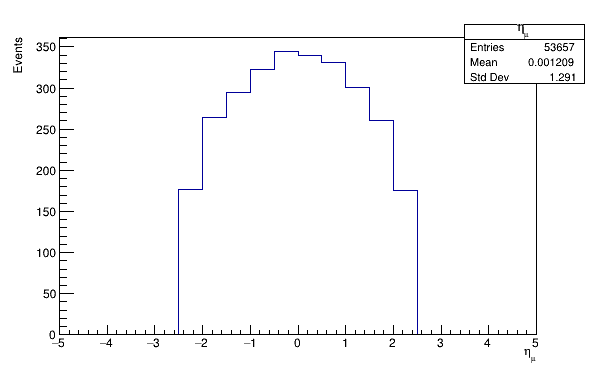

In [11]:
histogramas['muon1']['ww']['#eta_{#mu}'].Draw('hist')
canvas.Draw()

$\textbf{Comparación y Stack de los Histogramas}$

Normalmente para sobrelapar dos histogramas se puede hacer lo siguiente:

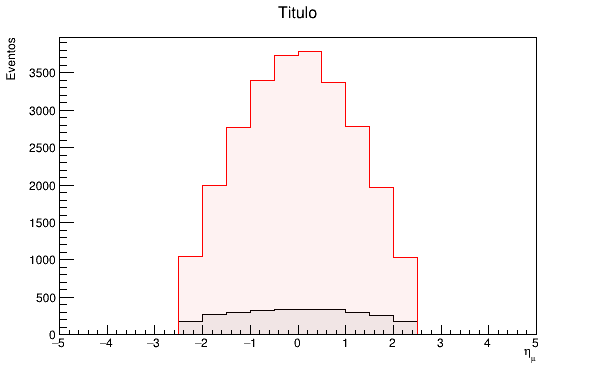

In [12]:
histo1 = histogramas['muon1']['ww']['#eta_{#mu}']
histo2 = histogramas['muon1']['ttbar']['#eta_{#mu}']
histo1.SetLineColor(1)
histo1.SetFillColorAlpha(1, 0.05)

histo2.SetLineColor(2)
histo2.SetFillColorAlpha(2, 0.05)

hs = THStack("Titulo", 'Titulo')
hs.Add(histo1)
hs.Add(histo2)

hs.SetTitle('Titulo; #eta_{#mu}; Eventos')
hs.Draw('histnostack')

canvas.Draw()

Con eso en mente se puede construir la siguiente función para facilitarnos el trabajo sobre lo que queremos graficar:

In [13]:
def Overlap_Histos(Particle, Cinematic_Variable, Histogramas, signals, XS, Path_CSV,
                   main_signal = 'z',ignorar = '', alpha = 0.05, Stack = False, 
                   Log = False, Grid = False, cortes_extra = False,):
    
    #Si Stack es False -> Se normaliza por unidad de area
    #Si Stack es True -> Se normaliza según el número de eventos
    
    canvas = TCanvas(Particle+Cinematic_Variable, " ", 600, 400)
    legend = TLegend(.8,.5,.9,.89)

    Histos = THStack('hist', Particle)
    
    signals.sort()
    for i in range(len(signals)):
        signal = signals[i]
        
        if(signal != ignorar and signal != main_signal):
        
            if (Histogramas[Particle][signal] != {}):
                histo = Histogramas[Particle][signal][Cinematic_Variable]
                histo.SetLineColor(i+1)
                histo.SetFillColorAlpha(i+1, alpha)
                histo.SetLineWidth(2)
                histo.SetDirectory(0)
                Histos.Add(histo)
                legend.AddEntry(histo,signal)
                legend.SetLineWidth(0)

            if (Stack): 
                N = Eficiencia(signal, Path_CSV, cut_flows_actualizado = cortes_extra)*Luminosidad()*XS[signal]
                histo.Scale(N/histo.Integral())

            else: histo.Scale(1.0/histo.Integral())
    
    signal = main_signal
    
    if (Histogramas[Particle][signal] != {}):
        histo = Histogramas[Particle][signal][Cinematic_Variable]
        histo.SetLineColor(i+2)
        histo.SetFillColorAlpha(i+2, alpha)
        histo.SetLineWidth(2)
        histo.SetDirectory(0)
        Histos.Add(histo)
        legend.AddEntry(histo,signal)
        legend.SetLineWidth(0)

    if (Stack): 
        N = Eficiencia(signal, Path_CSV, cut_flows_actualizado = cortes_extra)*Luminosidad()*XS[signal]
        histo.Scale(N/histo.Integral())

    else: histo.Scale(1.0/histo.Integral())
    
    
    if (Stack):
        Histos.Draw("hist")
        Histos.SetTitle(f'{Particle}; {Cinematic_Variable}; Events')
    else:
        Histos.Draw("histnostack")
        Histos.SetTitle(f'{Particle}; {Cinematic_Variable}; Events (u.a)')
    
    if Log: 
        canvas.SetLogy()
        Histos.SetMinimum(10)
        Histos.SetMaximum(1e8)
        
    if Grid: canvas.SetGrid()
    
    canvas.Draw()
    legend.Draw('same')
    
    return Histos, canvas, legend

Esta función retorna el arreglo de histogramas listos para graficar, según el que queramos simplemente hay que hacer lo siguiente: 

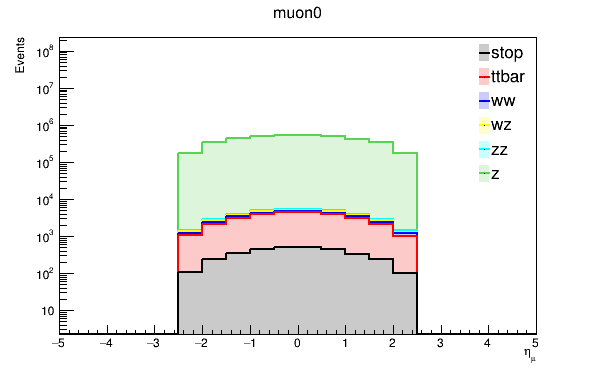

In [14]:
Histos, canvas, legend = Overlap_Histos("muon0", '#eta_{#mu}', histogramas, signals, XS, Path_CSV = personal_folder, 
                                        Stack = True, ignorar = 'w_jets', alpha = 0.2, Log = True)

Intentemoslo para la masa reconstruída del Z con Stack y escala logarítmica:

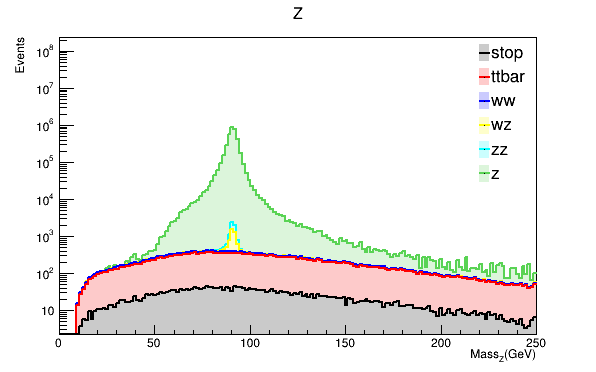

In [15]:
Histos, canvas, legend = Overlap_Histos("Z", 'Mass_{Z}(GeV)', histogramas, signals, XS, Path_CSV = personal_folder,
                                        Stack = True, ignorar = 'w_jets', alpha = 0.2, Log = True)
#Histos.GetXaxis().SetLimits(66,116) #Ese es el filtro del siguiente capitulo, esta es una forma de aplicarlo simplemente cambiando el rango de los ejes